##  **Recursive System Identification**  
week9, group 2


# Recursive System Identification — Brief Introduction



## 1) Definition
**Recursive System Identification (RSI)** estimates a system model **online**, updating parameters each time a new data sample arrives. A generic recursive update is
$$
\theta_k=\theta_{k-1}+K_k\,e_k,\qquad
e_k = y_k-\phi_k^\top \theta_{k-1},
$$
where $\,\theta_k\,$ are the parameters at time $k$, $\,\phi_k\,$ is the regressor built from recent inputs/outputs, $\,y_k\,$ is the measured output, $\,e_k\,$ is the prediction error, and $\,K_k\,$ is a data-driven gain.

## 2) When and why use it
- **Time-varying / drifting systems:** parameters adapt as the plant changes, events such as equipment aging, catalyst deactivation, bioprocess rheology/surfactants changing, fouling, media shifts, etc.
- **Change / fault detection:** sudden parameter shifts or growing residuals flag anomalies in real time, such as a valve sticking, a leak, a probe issue, etc.

## 3) How it works
1. **Choose a model structure** (e.g., ARX/ARMAX, ODE) and initialize $\,\theta_0, P_0\,$.
2. **At each sample:** form $\,\phi_k\,$ → predict $\,\hat{y}_k=\phi_k^\top\theta_{k-1}\,$ → compute $\,e_k\,$ → update $\,\theta_k\,$ with a gain $\,K_k$.
3. **Down-weight old data** (forgetting factor or sliding window) so parameters track genuine changes.
4. **Monitor residuals/parameters** to detect drifts or abrupt changes; ensure inputs excite the dynamics you want to identify.




## 4) Most common methods

### Presented today:
- Recursive Least Squares (RLS)
- Prediction Error Method (PEM)
- Wide-Array of Nonlinear Dynamic Approximations (WyNDA)

### Also famous:
- Kalman Filter


# Recursive Least Squares (RLS)

## Intuition

We estimate parameters of a **linear-in-parameters** model

$$
y_t = \phi_t^\top \theta + e_t,
$$

where $\phi_t$ is the regressor (e.g., past inputs and outputs) and $\theta$ are the unknown parameters.

**Batch Least Squares (LS)** solves

$$
\min_\theta \sum_{i=1}^t (y_i - \phi_i^\top \theta)^2
$$

at every time step, which is computationally expensive.

**Recursive Least Squares (RLS)** instead updates $\theta$ *incrementally* as new data arrives, using matrix identities.

To handle **time-varying systems**, we introduce a *forgetting factor* $\lambda$:

$$
J_t(\theta) = \sum_{i=1}^{t} \lambda^{t-i} (y_i - \phi_i^\top \theta)^2, \quad 0 < \lambda \le 1.
$$

A smaller $\lambda$ gives more weight to recent samples, improving tracking.



##  Core RLS Equations

Given $(\phi_t, y_t)$, and previous estimates $\theta_{t-1}$ and $P_{t-1}$:

1. **Innovation (prediction error)**  
   $$
   e_t = y_t - \phi_t^\top \theta_{t-1}
   $$

2. **Gain vector**  
   $$
   K_t = \frac{P_{t-1} \phi_t}{\lambda + \phi_t^\top P_{t-1} \phi_t}
   $$

3. **Parameter update**  
   $$
   \theta_t = \theta_{t-1} + K_t e_t
   $$

4. **Covariance update**  
   $$
   P_t = \frac{1}{\lambda} \left( P_{t-1} - K_t \phi_t^\top P_{t-1} \right)
   $$


## Initialization and Forgetting

- $\theta_0$: usually set to zeros  
- $P_0 = \alpha I$: large $\alpha$ (e.g., $10^3$–$10^6$) expresses high initial uncertainty  
- $\lambda$:  
  - $1.0$: no forgetting (stationary system)  
  - $0.95 \le \lambda < 1.0$: adaptive, for time-varying systems




## Example: ARX Model

For an ARX$(n_a, n_b, n_k)$ system:

$$
y_t + a_1 y_{t-1} + \cdots + a_{n_a} y_{t-n_a}
= b_1 u_{t-n_k} + \cdots + b_{n_b} u_{t-n_k-n_b+1} + e_t
$$

Define the regressor and parameter vectors:

$$
\phi_t =
\begin{bmatrix}
 -y_{t-1} & \cdots & -y_{t-n_a} & u_{t-n_k} & \cdots & u_{t-n_k-n_b+1}
\end{bmatrix}^\top
$$

$$
\theta =
\begin{bmatrix}
 a_1 & \cdots & a_{n_a} & b_1 & \cdots & b_{n_b}
\end{bmatrix}^\top
$$

## Summary (RLS)

- RLS updates model parameters online using matrix identities.  
- The forgetting factor $\lambda$ enables tracking of time-varying systems.  
- Often used in **adaptive system identification** and **online control**.

---

### Next step

We’ll now implement RLS as a Python class and test it on a simple ARX example.

# Example System: Mass–Spring–Damper

We consider a **discrete-time** version of a continuous mass–spring–damper system:

$$
m \ddot{x}(t) + c \dot{x}(t) + k x(t) = u(t)
$$

where:
- $x(t)$ is the position,
- $u(t)$ is the external force,
- $m$ is the mass,
- $c$ is the damping coefficient,
- $k$ is the stiffness.

---

## Discretization

Using Euler discretization with sampling time $\Delta t$, we get:

$$
\begin{aligned}
x_{t+1} &= x_t + \Delta t \, v_t, \\
v_{t+1} &= v_t + \Delta t \, \frac{1}{m} \left( -c v_t - k x_t + u_t \right),
\end{aligned}
$$

where $v_t = \dot{x}(t)$.

We can write this in **state-space form**:

$$
\begin{bmatrix} x_{t+1} \\ v_{t+1} \end{bmatrix}
=
\begin{bmatrix}
1 & \Delta t \\
-\frac{k \Delta t}{m} & 1 - \frac{c \Delta t}{m}
\end{bmatrix}
\begin{bmatrix} x_t \\ v_t \end{bmatrix}
+
\begin{bmatrix} 0 \\ \frac{\Delta t}{m} \end{bmatrix} u_t
$$



## Parameter Estimation Goal

Suppose the true parameters are unknown:
- $m = 1.0$
- $c = 0.5$
- $k = 2.0$

We aim to **estimate** the parameters $\theta = [k, c, 1/m]^\top$ from measurements of $(x_t, v_t, u_t)$.

To do this, we can rearrange the second equation:

$$
v_{t+1} - v_t = \Delta t \left(-\frac{k}{m} x_t - \frac{c}{m} v_t + \frac{1}{m} u_t\right)
$$

This can be written as a **linear regression**:

$$
y_t = \phi_t^\top \theta + e_t
$$

with:
$$
\begin{aligned}
y_t &= \frac{v_{t+1} - v_t}{\Delta t}, \\
\phi_t &= \begin{bmatrix} -x_t & -v_t & u_t \end{bmatrix}^\top, \\
\theta &= \begin{bmatrix} k/m & c/m & 1/m \end{bmatrix}^\top.
\end{aligned}
$$

We can now use **Recursive Least Squares (RLS)** to estimate $\theta$ online from streaming data $(x_t, v_t, u_t)$.

Example (RLS)

=== RLS estimation of Mass–Spring–Damper (NumPy only) ===
True params:   m=1.0000, c=0.5000, k=2.0000
Est (last 10): m=0.9754, c=0.8247, k=1.9828

Avg |theta - theta_true| over tail: 1.3452e-01
Mean |innovation| over tail:        8.1488e-01


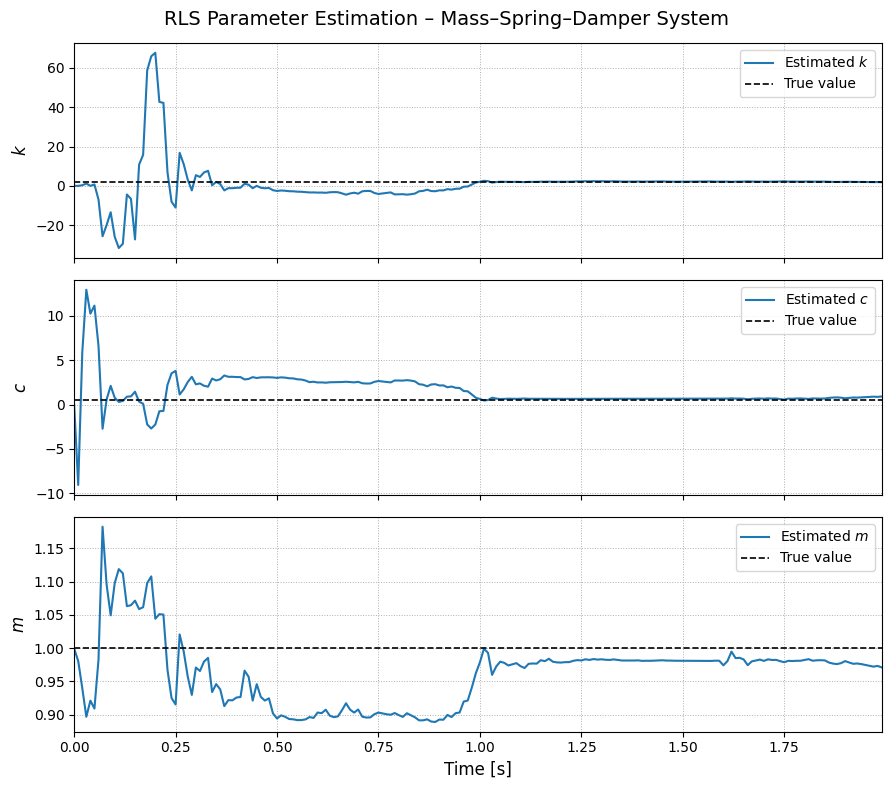

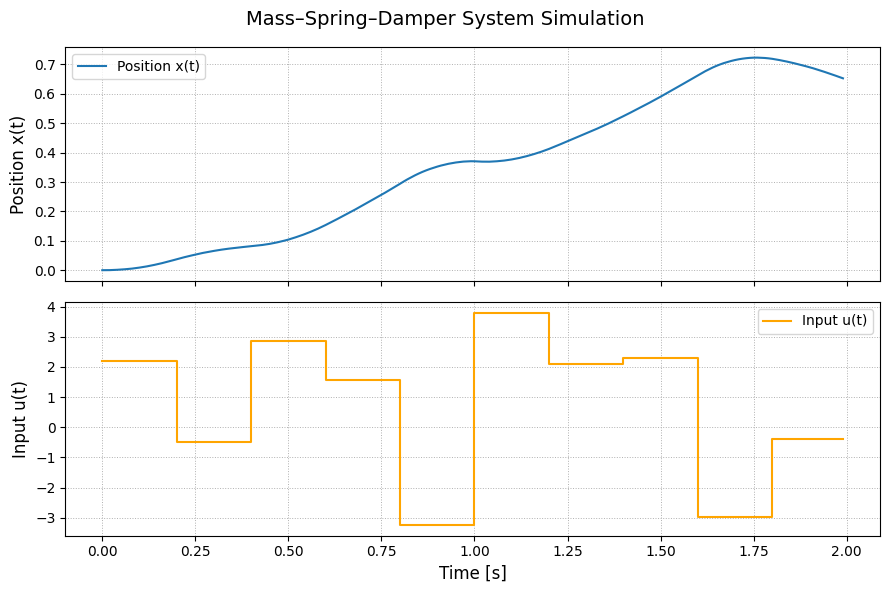

In [ ]:
import numpy as np

# ============================================================
# Mass–Spring–Damper simulation + RLS (NumPy only)
# ============================================================

def simulate_msd(T, dt, m, c, k, u_seq, x0=0.0, v0=0.0, noise_std=0.0, seed=0):
    """
    Simulate a discrete-time mass–spring–damper system:
        x_{t+1} = x_t + dt * v_t
        v_{t+1} = v_t + dt * (1/m) * ( -c v_t - k x_t + u_t )

    Args:
        T (int): number of simulation steps
        dt (float): sampling time
        m, c, k (float): true system parameters
        u_seq (ndarray[T]): input force sequence
        x0, v0 (float): initial states
        noise_std (float): std. dev. of additive measurement noise on v
        seed (int): RNG seed for noise

    Returns:
        x (ndarray[T+1]), v (ndarray[T+1]), u (ndarray[T])
    """
    rng = np.random.default_rng(seed)
    x = np.zeros(T + 1)
    v = np.zeros(T + 1)
    x[0], v[0] = x0, v0

    for t in range(T):
        # state update
        x[t + 1] = x[t] + dt * v[t]
        v[t + 1] = v[t] + dt * (1.0 / m) * (-c * v[t] - k * x[t] + u_seq[t])

        # optional measurement noise on velocity (simulate sensor noise)
        if noise_std > 0.0:
            v[t + 1] += rng.normal(0.0, noise_std)

    return x, v, u_seq


class RLS:
    """
    Recursive Least Squares with forgetting.

    Model: y_t = phi_t^T theta + e_t
    Updates:
        e_t = y_t - phi_t^T theta_{t-1}
        K_t = P_{t-1} phi_t / (lambda + phi_t^T P_{t-1} phi_t)
        theta_t = theta_{t-1} + K_t e_t
        P_t = (1/lambda) * (P_{t-1} - K_t phi_t^T P_{t-1})

    Args:
        n_params (int): dimension of theta
        lam (float): forgetting factor in (0,1], default 0.99
        P0_scale (float): initial covariance scale (alpha*I), default 1e6
        theta0 (ndarray[n_params], optional): initial guess
    """
    def __init__(self, n_params: int, lam: float = 0.99, P0_scale: float = 1e6, theta0=None):
        self.n = n_params
        self.lam = float(lam)
        self.theta = np.zeros(self.n) if theta0 is None else np.asarray(theta0, dtype=float).copy()
        self.P = P0_scale * np.eye(self.n, dtype=float)

    def update(self, phi_t: np.ndarray, y_t: float):
        phi = np.asarray(phi_t, dtype=float).reshape(-1)          # (n,)
        y = float(y_t)

        # Innovation
        e = y - phi @ self.theta

        # Gain
        denom = self.lam + phi @ (self.P @ phi)
        K = (self.P @ phi) / denom

        # Parameter & covariance update
        self.theta = self.theta + K * e
        self.P = (self.P - np.outer(K, phi) @ self.P) / self.lam

        return self.theta, e


# ------------------------------------------------------------
# Example setup
# ------------------------------------------------------------
if __name__ == "__main__":
    # True system
    m_true = 1.0
    c_true = 0.5
    k_true = 2.0

    # Discretization
    dt = 0.01
    T = 200  # number of steps

    # Excitation: piecewise-constant random input (good persistence of excitation)
    np.random.seed(42)
    rng = np.random.default_rng(42)
    hold = 20
    u_blocks = rng.uniform(-4.0, 4.0, size=T // hold + 1)
    u = np.repeat(u_blocks, hold)[:T]

    # Simulate system (add small velocity noise to be realistic)
    x, v, u_sim = simulate_msd(T=T, dt=dt, m=m_true, c=c_true, k=k_true,
                               u_seq=u, x0=0.0, v0=0.0, noise_std=0.01, seed=7)

    # --------------------------------------------------------
    # Build regression for RLS
    # y_t = (v_{t+1} - v_t)/dt
    # phi_t = [-x_t, -v_t, u_t]^T
    # theta = [k/m, c/m, 1/m]^T
    # --------------------------------------------------------
    y = (v[1:] - v[:-1]) / dt
    phi = np.stack([-x[:-1], -v[:-1], u_sim], axis=1)  # shape (T, 3)

    # RLS init
    rls = RLS(n_params=3, lam=0.995, P0_scale=1e4, theta0=np.zeros(3))

    # Run online
    theta_hist = np.zeros((T, 3))
    err_hist = np.zeros(T)
    for t in range(T):
        theta_t, e_t = rls.update(phi[t], y[t])
        theta_hist[t] = theta_t
        err_hist[t] = e_t

    # Convert theta to physical parameters
    # theta = [k/m, c/m, 1/m]
    inv_m_est = theta_hist[:, 2]
    # Avoid division by tiny numbers during transient
    m_est = np.where(np.abs(inv_m_est) > 1e-8, 1.0 / inv_m_est, np.nan)
    k_over_m = theta_hist[:, 0]
    c_over_m = theta_hist[:, 1]
    k_est = k_over_m * m_est
    c_est = c_over_m * m_est

    # Report final estimates (use last 500 samples averaged to smooth noise)
    tail_len = min(T, 10)
    tail = slice(T - tail_len, T)

    m_hat = np.nanmean(m_est[tail])
    c_hat = np.nanmean(c_est[tail])
    k_hat = np.nanmean(k_est[tail])

    print("=== RLS estimation of Mass–Spring–Damper (NumPy only) ===")
    print(f"True params:   m={m_true:.4f}, c={c_true:.4f}, k={k_true:.4f}")
    print(f"Est (last 10): m={m_hat:.4f}, c={c_hat:.4f}, k={k_hat:.4f}")
    print()
    # Simple quality metrics
    mae_theta = np.nanmean(np.abs(np.array([k_true/m_true, c_true/m_true, 1.0/m_true]) - theta_hist[tail].mean(axis=0)))
    print(f"Avg |theta - theta_true| over tail: {mae_theta:.4e}")
    print(f"Mean |innovation| over tail:        {np.mean(np.abs(err_hist[tail])):.4e}")

import matplotlib.pyplot as plt

# ============================================================
# Plot RLS convergence
# ============================================================

t_axis = np.arange(T) * dt

fig, axes = plt.subplots(3, 1, figsize=(9, 8), sharex=True)
params = [k_est, c_est, m_est]
true_vals = [k_true, c_true, m_true]
labels = [r"$k$", r"$c$", r"$m$"]

for i, ax in enumerate(axes):
    ax.plot(t_axis, params[i], label=f"Estimated {labels[i]}")
    ax.axhline(true_vals[i], color="k", linestyle="--", linewidth=1.2, label="True value")
    ax.set_ylabel(labels[i], fontsize=12)
    ax.grid(True, linestyle=":", linewidth=0.7)
    ax.legend()
    ax.set_xlim(t_axis[0], t_axis[-1])

axes[-1].set_xlabel("Time [s]", fontsize=12)
fig.suptitle("RLS Parameter Estimation – Mass–Spring–Damper System", fontsize=14)
plt.tight_layout()
plt.show()


# Plots position and input
fig2, ax2 = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
ax2[0].plot(t_axis, x[:-1], label="Position x(t)")
ax2[0].set_ylabel("Position x(t)", fontsize=12)
ax2[0].grid(True, linestyle=":", linewidth=0.7)
ax2[0].legend()
ax2[1].step(t_axis, u_sim, where='post', label="Input u(t)", color='orange')
ax2[1].set_ylabel("Input u(t)", fontsize=12)
ax2[1].set_xlabel("Time [s]", fontsize=12)
ax2[1].grid(True, linestyle=":", linewidth=0.7)
ax2[1].legend()
fig2.suptitle("Mass–Spring–Damper System Simulation", fontsize=14)
plt.tight_layout()
plt.show()

## PEM: Prediction Error Method

PEM is a parametric estimation technique used to fit models (e.g. ARX) to data by minimizing the prediction error between observed outputs and model-predicted outputs.

### Intuition and core idea

* Pick a model **structure**
$$
y(t) = G(q,θ)u(t) + H(q,θ)e(t)
$$
<div align="center">
with G and H transfer functions
</div>

<br>

* For each parameter set $\theta$, compute the **Prediction error** - how well the model predicts the data
$$
\varepsilon(t, θ) = y(t) - \hat{y}(t | θ)
$$

<br>

* **Optimise $\theta$** to minimize the squared prediction errors

$$
\hat{\theta}{PEM} = \arg \min*{\theta} \frac{1}{N} \sum_{t=1}^{N} \varepsilon^2(t, \theta)
$$

<div align="center">
where $\frac{1}{N} \sum_{t=1}^{N} \varepsilon^2(t, \theta)$ is the loss function
</div>

<br>

This makes PEM the **maximum likelyhood estimator** when the errors e(t) are Gaussian.

<br>

#### Example: MATLAB pem function


* Data and model structure


Estimate the parameters of a nonlinear grey-box model to fit DC motor data

The model has one input u(t) and two outputs y1(t) and y2(t).

* Steps
1. Estimate the parameters to initialise PEM: init_sys
2. Find the best parameter set using pem(): sys
3. Compare:
  >
   - The observed data: Validation data (y1 or y2)
   - The prediction from the model with initial parameters: sys_ini
   - The prediction from the model with parameters found with pem: sys



In [ ]:
from IPython.display import Image
Image(url='https://www.mathworks.com/help/examples/ident/win64/EstimateNonlinearGreyBoxModelExample_01.png', width=800)

## WyNDA: Wide-Array of Nonlinear Dynamic Approximations

### Fundamental Concept
Given first-order ODE:
$$\begin{align}
\dot{x}(t)&=f(x(t),u(t),\theta(t)) \\
y(k)&=x(k)+\epsilon(k)
\end{align}$$
where $\epsilon(k)\sim\mathcal{N}(0,R(k))$ is the measurement noise.\
The approximation model:
$$\begin{align}
x(k+1)&=x(k)+\Psi(y(k),u(k))\theta(k)+\eta(k) \quad \textrm{or} \\
x(k+1)&=x(k)+g(x(k),u(k))+\Psi(y(k),u(k))\theta(k)+\eta(k)
\end{align}$$
where $\eta(k)\sim\mathcal{N}(0,Q(k))$ denotes the approximation uncertainty and $g:\mathbb{R}^{n}\times\mathbb{R}^{r}\rightarrow\mathbb{R}^n$ is the prior known function.\
The approximation function $\Psi(y(k),u(k))=\Psi(*)$:
$$\Psi(*)=\begin{bmatrix}
\Phi_1(*) & 0 & \cdots & 0 \\ 0 & \Phi_2(*) & \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \cdots & \Phi_n(*)
\end{bmatrix}$$
with the choice of the vector basis function:
$$\begin{align}
\Phi_h(*)&=\begin{bmatrix}\cdots & y_i(k) & y_i^2(k) & \sin(y_i(k)) & \cos(y_i(k)) & \cdots\end{bmatrix} \quad \textrm{and} \\
\Phi_{h+1}(*)&=\begin{bmatrix}\cdots & u_j(k) & u_j^2(k) & \sin(u_j(k)) & \cos(u_j(k)) & \cdots\end{bmatrix} \quad \textrm{or} \quad \Phi_h(*) = \Phi_{h+1}(*)
\end{align}$$

The approximation method, by reformulating the problem:
$$\begin{bmatrix}x(k+1)\\\theta(k+1)\end{bmatrix}=\begin{bmatrix}I&\Psi(*)\\0&I\end{bmatrix}\begin{bmatrix}x(k)\\\theta(k)\end{bmatrix}+\begin{bmatrix}\eta(k)\\\xi(k)\end{bmatrix}$$
the estimation of $\hat{x}(k)$ and $\hat{\theta}(k)$ will be performed by DSE algorithms.

### Example #1
#### Mass-Spring-Damper System
ODE model:
$$\begin{align}
\dot{x}(t)&=v(t) \\
\dot{v}(t)&=-\frac{k}{m}x(t)-\frac{b}{m}v(t)+\frac{1}{m}u(t)
\end{align}$$
with $m=1,k=5,b=2$ and $u(t)=2\sin(\pi t)$.
#### WyNDA Configuration
Basis function:
$$\begin{align} \Phi_1(*)& = \Phi_2(*) = \begin{bmatrix} x(k) & v(k) & u(k) & \sin{x(k)} & \cos{x(k)} & \sin{v(k)} & \cos{v(k)} \end{bmatrix} \quad \longrightarrow \quad \textrm{up to}\;\theta_{16} \end{align}$$
Parameter solution:
$$\begin{align}-\frac{k}{m}\approx\frac{\theta_{9}}{\Delta t}, \; -\frac{b}{m}\approx\frac{\theta_{10}}{\Delta t}, \; \frac{1}{m}\approx\frac{\theta_{11}}{\Delta t} \\
k\approx-\frac{\theta_{9}\theta_{11}}{\Delta t^2}, \; b\approx-\frac{\theta_{10}\theta_{11}}{\Delta t^2}, \; m\approx\frac{\Delta t}{\theta_{11}}\end{align}$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# ## System Setup

dt = 0.001      # sampling time
tf = 10.0       # final time
t = np.arange(0, tf, dt)

# True system parameters
m_true = 1.0     # mass
b_true = 2.0     # damping
k_true = 5.0     # stiffness

# Discrete-time state-space model (approx using forward Euler)
A = np.array([[0, 1],
              [-k_true/m_true, -b_true/m_true]])
B = np.array([[0],
              [1/m_true]])
C = np.array([[1, 0],[0, 1]])

# %%
# ## Initialize States

x = np.array([[0.5],  # position
              [0.0]]) # velocity
xhat = x.copy()
thetahat = np.zeros((16, 1))   # parameter vector

# %%
# ## AO Initialization

n = 2
r = thetahat.shape[0]
Rx = np.eye(n)
Rt = np.eye(n)
Px = 5 * np.eye(n)
Pt = 5 * np.eye(r)
Gamma = np.zeros((n, r))
lambdav = 0.995
lambdat = 0.999

# %%
# ## Input Signal (sinusoidal excitation)

u = 2 * np.sin(2*np.pi*0.5*t)   # sine input

# %%
# ## Data Storage

xArray = []
xhatArray = []
thetahatArray = []
yArray = []

# %%
# ## Simulation Loop

for k in range(len(t)):

    # --- true system update ---
    x = x + A @ x * dt + B * u[k] * dt
    y = C @ x + dt * 0.01 * np.random.randn(2, 1)  # with small noise

    # --- basis matrix Phi(y, u) ---
    y1, y2 = y
    Phi = np.block([
        [y1, y2, u[k], np.sin(y1), np.cos(y1), np.sin(y2), np.cos(y2), 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, y1, y2, u[k], np.sin(y1), np.cos(y1), np.sin(y2), np.cos(y2), 1]
    ])

    # --- adaptive observer update ---
    Kx = Px @ C.T @ np.linalg.inv(C @ Px @ C.T + Rx)
    Kt = Pt @ Gamma.T @ C.T @ np.linalg.inv(C @ Gamma @ Pt @ Gamma.T @ C.T + Rt)
    Gamma = (np.eye(n) - Kx @ C) @ Gamma

    xhat = xhat + (Kx + Gamma @ Kt) @ (y - C @ xhat)
    thetahat = thetahat - Kt @ (y - C @ xhat)

    # state prediction
    xhat = xhat + Phi @ thetahat

    # covariance updates
    Px = (1 / lambdav) * (np.eye(n) - Kx @ C) @ Px
    Pt = (1 / lambdat) * (np.eye(r) - Kt @ C @ Gamma) @ Pt
    Gamma = np.eye(n) @ Gamma - Phi

    # record data
    xArray.append(x.flatten())
    xhatArray.append(xhat.flatten())
    yArray.append(y.flatten())
    thetahatArray.append(thetahat.flatten())

# %%
# ## Convert logs to arrays

xArray = np.array(xArray).T
xhatArray = np.array(xhatArray).T
yArray = np.array(yArray).T
thetahatArray = np.array(thetahatArray).T

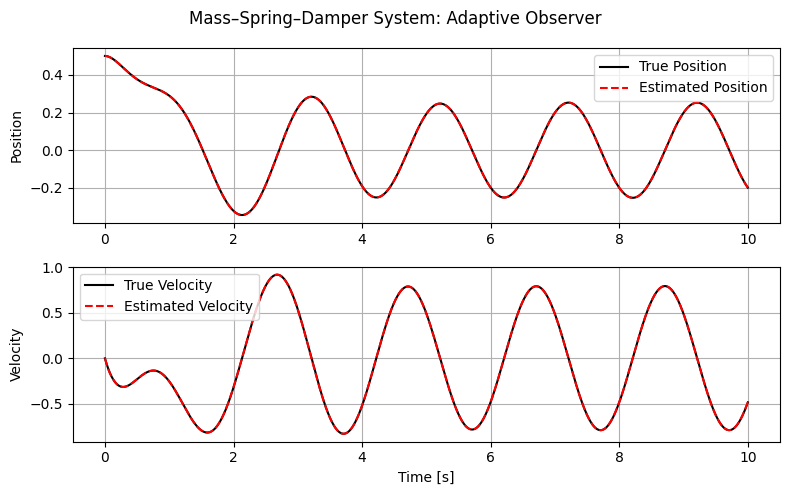

In [ ]:
# --- Plot results ---
plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
plt.plot(t, xArray[0, :], 'k', label='True Position')
plt.plot(t, xhatArray[0, :], 'r--', label='Estimated Position')
plt.ylabel('Position')
plt.legend(); plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, xArray[1, :], 'k', label='True Velocity')
plt.plot(t, xhatArray[1, :], 'r--', label='Estimated Velocity')
plt.xlabel('Time [s]')
plt.ylabel('Velocity')
plt.legend(); plt.grid(True)

plt.suptitle('Mass–Spring–Damper System: Adaptive Observer')
plt.tight_layout()
plt.show()

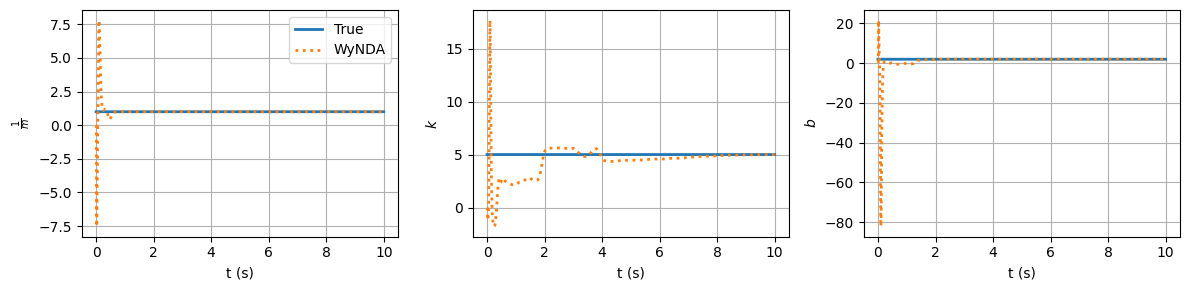

In [ ]:
# ## Parameter Estimation Plots

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs = axs.flatten()

# m parameter
axs[0].plot(t, 1/m_true*np.ones_like(t), '-', linewidth=2)
axs[0].plot(t, thetahatArray[10]/dt, ':', linewidth=2)
axs[0].set_ylabel(r'$\frac{1}{m}$')
axs[0].legend(['True', 'WyNDA'])
axs[0].set_xlabel('t (s)')
axs[0].grid(True)

# k parameter
axs[1].plot(t, k_true*np.ones_like(t), '-', linewidth=2)
axs[1].plot(t, -thetahatArray[8]/dt*thetahatArray[10]/dt, ':', linewidth=2)
axs[1].set_ylabel(r'$k$')
axs[1].set_xlabel('t (s)')
axs[1].grid(True)

# b parameter
axs[2].plot(t, b_true*np.ones_like(t), '-', linewidth=2)
axs[2].plot(t, -thetahatArray[9]/dt*thetahatArray[10]/dt, ':', linewidth=2)
axs[2].set_ylabel(r'$b$')
axs[2].set_xlabel('t (s)')
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
np.set_printoptions(suppress=True, formatter={'float_kind':lambda x: f"{x:6.2f}"})
Coeff = (1/dt) * np.vstack([
    thetahatArray[0:r//n, -1],
    thetahatArray[r//n:r, -1]
])
print("Estimated Coefficients:\n")
print(Coeff)

Estimated Coefficients:

[[ -0.00   1.00  -0.00   0.00  -0.00  -0.00  -0.00   0.00]
 [ -5.00  -2.01   1.00  -0.02  -0.01   0.00  -0.00   0.02]]



### Example #2
#### Lorentz System
ODE model:
$$\begin{align}
\dot{p}(t)&=\sigma(q(t)-p(t)) \\
\dot{q}(t)&=p(t)(\rho-r(t))-q(t) \\
\dot{r}(t)&=p(t)q(t)-\beta r(t)
\end{align}$$
with $\sigma=10,\rho=28,\beta=\frac{8}{3}$.
#### WyNDA Configuration
Basis function:
$$\begin{align} \Phi_1(*)& = \Phi_2(*) = \Phi_3(*) = \\
&\begin{bmatrix} 1 & p(k) & q(k) & r(k) & p^2(k) & q^2(k) & r^2(k) & p(k)q(k) & p(k)r(k) & q(k)r(k) & \sin(p(k)) & \sin(q(k)) & \sin(r(k)) & \cos(p(k)) & \cos(q(k)) & \cos(r(k)) \end{bmatrix} \\
&\quad \longrightarrow \quad \textrm{up to}\;\theta_{48} \end{align}$$
Parameter solution:
$$\sigma\approx-\frac{\theta_2}{\Delta t}\approx\frac{\theta_3}{\Delta t}, \; \rho\approx\frac{\theta_{18}}{\Delta t}, \; \beta\approx-\frac{\theta_{36}}{\Delta t}$$


In [ ]:
#import
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Lorentz System

# ## Time Horizon and System Dimensions

tf = 10.0
dt = 0.001
t = np.arange(dt, tf + dt, dt)

n = 3   # number of system states
r = 48  # number of estimated coefficients

# ## System Matrices and Noise

A = np.eye(n)
C = np.eye(n)
R = 1.0  # measurement noise coefficient

# ## True Parameters (Lorenz System)

sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

# ## Estimator Initialization

lambdav = 0.995
lambdat = 0.999
Rx = np.eye(n)
Rt = np.eye(n)
Px = 0.1 * np.eye(n)
Pt = 0.1 * np.eye(r)
Gamma = np.zeros((n, r))

# ## Initial Conditions

x = np.array([-8.0, 7.0, 27.0])
xbar = x.copy()
xhat = x.copy()
y = x.copy()

thetabar = np.zeros(r)
thetahat = np.zeros(r)

# ## Storage Arrays

xArray = []
xbarArray = []
xhatArray = []
yArray = []
thetabarArray = []
thetahatArray = []

# ## Simulation Loop

for _ in range(len(t)):

    # --- Data logging ---
    xArray.append(x.copy())
    xbarArray.append(xbar.copy())
    xhatArray.append(xhat.copy())
    yArray.append(y.copy())
    thetabarArray.append(thetabar.copy())
    thetahatArray.append(thetahat.copy())

    # --- Runge-Kutta integration (Lorenz system) ---
    def f_lorenz(x):
        dx1 = sigma * (x[1] - x[0])
        dx2 = x[0] * (rho - x[2]) - x[1]
        dx3 = x[0] * x[1] - beta * x[2]
        return np.array([dx1, dx2, dx3])

    k1 = f_lorenz(x)
    k2 = f_lorenz(x + 0.5 * dt * k1)
    k3 = f_lorenz(x + 0.5 * dt * k2)
    k4 = f_lorenz(x + dt * k3)
    x = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

    # --- Noisy Measurement ---
    y = C @ x + dt * R**2 * np.random.randn(n)

    # --- Basis matrix Φ (48x1 features across 3 outputs) ---
    y1, y2, y3 = y
    phi_row = np.array([
        1, y1, y2, y3,
        y1**2, y2**2, y3**2,
        y1*y2, y1*y3, y2*y3,
        np.sin(y1), np.sin(y2), np.sin(y3),
        np.cos(y1), np.cos(y2), np.cos(y3)
    ])
    Phi = np.block([
        [phi_row, np.zeros(32)],
        [np.zeros(16), phi_row, np.zeros(16)],
        [np.zeros(32), phi_row]
    ])

    # --- Adaptive Observer ---
    Kx = Px @ C.T @ np.linalg.inv(C @ Px @ C.T + Rx)
    Kt = Pt @ Gamma.T @ C.T @ np.linalg.inv(C @ Gamma @ Pt @ Gamma.T @ C.T + Rt)
    Gamma = (np.eye(n) - Kx @ C) @ Gamma

    xbar = xbar + (Kx + Gamma @ Kt) @ (y - C @ xbar)
    thetabar = thetabar - Kt @ (y - C @ xbar)
    xbar = A @ xbar + Phi @ thetabar

    Px = (1 / lambdav) * (np.eye(n) - Kx @ C) @ Px
    Pt = (1 / lambdat) * (np.eye(r) - Kt @ C @ Gamma) @ Pt
    Gamma = np.eye(n) @ Gamma - Phi

# ## Convert logged data to arrays

xArray = np.array(xArray).T
xbarArray = np.array(xbarArray).T
xhatArray = np.array(xhatArray).T
yArray = np.array(yArray).T
thetabarArray = np.array(thetabarArray).T
thetahatArray = np.array(thetahatArray).T

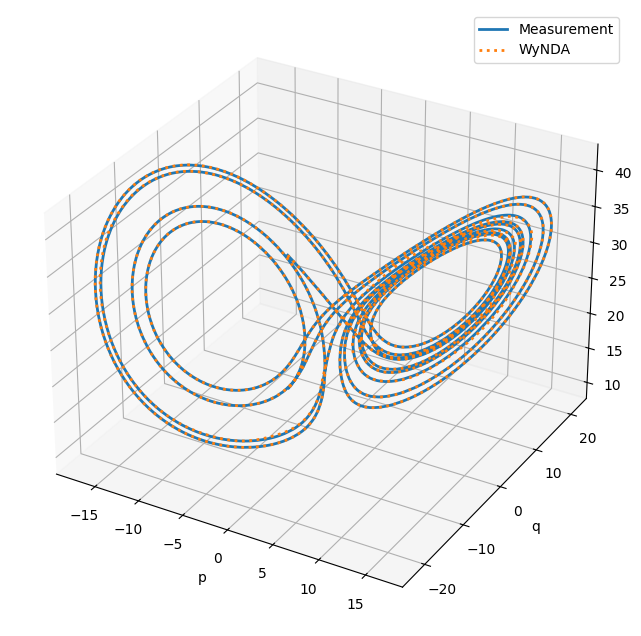

In [ ]:
# ## 3D Trajectories Plot

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(yArray[0], yArray[1], yArray[2], '-', linewidth=2, label='Measurement')
ax.plot(xbarArray[0], xbarArray[1], xbarArray[2], ':', linewidth=2, label='WyNDA')
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('r')
ax.legend()
ax.grid(True)
plt.show()

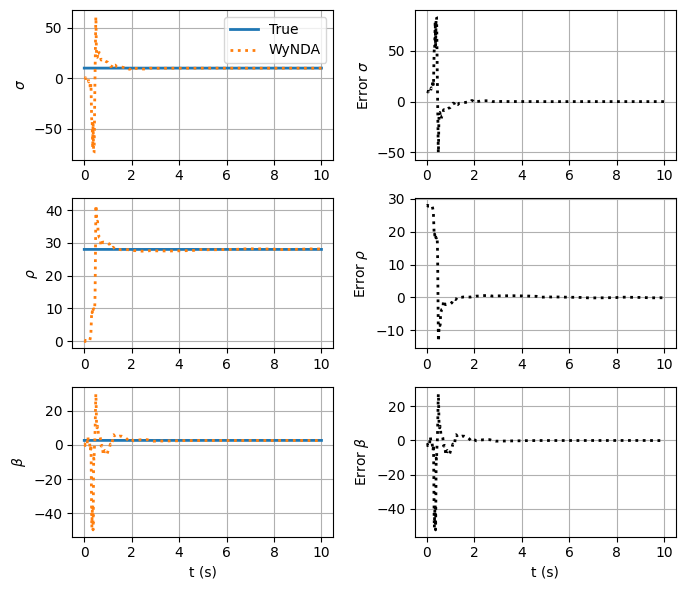

In [ ]:
# ## Parameter Estimation Plots

fig, axs = plt.subplots(3, 2, figsize=(7, 6))
axs = axs.flatten()

# σ parameter
axs[0].plot(t, sigma*np.ones_like(t), '-', linewidth=2)
axs[0].plot(t, thetabarArray[2]/dt, ':', linewidth=2)
axs[0].set_ylabel(r'$\sigma$')
axs[0].legend(['True', 'WyNDA'])
axs[0].grid(True)

axs[1].plot(t, sigma*np.ones_like(t) - thetabarArray[2]/dt, ':k', linewidth=2)
axs[1].set_ylabel(r'Error $\sigma$')
axs[1].grid(True)

# ρ parameter
axs[2].plot(t, rho*np.ones_like(t), '-', linewidth=2)
axs[2].plot(t, thetabarArray[17]/dt, ':', linewidth=2)
axs[2].set_ylabel(r'$\rho$')
axs[2].grid(True)

axs[3].plot(t, rho*np.ones_like(t) - thetabarArray[17]/dt, ':k', linewidth=2)
axs[3].set_ylabel(r'Error $\rho$')
axs[3].grid(True)

# β parameter
axs[4].plot(t, beta*np.ones_like(t), '-', linewidth=2)
axs[4].plot(t, -thetabarArray[35]/dt, ':', linewidth=2)
axs[4].set_ylabel(r'$\beta$')
axs[4].set_xlabel('t (s)')
axs[4].grid(True)

axs[5].plot(t, -beta*np.ones_like(t) - thetabarArray[35]/dt, ':k', linewidth=2)
axs[5].set_ylabel(r'Error $\beta$')
axs[5].set_xlabel('t (s)')
axs[5].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
np.set_printoptions(suppress=True, formatter={'float_kind':lambda x: f"{x:6.2f}"})

Coeff = (1/dt) * np.vstack([
    thetabarArray[0:r//n, -1],
    thetabarArray[r//n:2*(r//n), -1],
    thetabarArray[2*(r//n):r, -1]
])

print("Estimated Coefficients:\n")
print(Coeff)

Estimated Coefficients:

[[ -0.01  -9.81   9.95   0.00   0.00  -0.00  -0.00   0.00  -0.00  -0.00
    0.00  -0.00  -0.00   0.00  -0.00   0.00]
 [ -0.28  28.15  -1.01   0.06   0.02  -0.00  -0.00  -0.01  -1.00  -0.00
    0.02  -0.19   0.15   0.01  -0.00   0.03]
 [ -0.84   0.04  -0.01  -2.56   0.00   0.01  -0.00   0.99  -0.00   0.00
   -0.01  -0.06  -0.08   0.06   0.01  -0.05]]


### Pros
* Computationally light
* Online discovery
* Handle nonlinearities
* In-loop with feedback control and/or digital twin

### Cons
* Required high complexity for higher capability (high variation of $\Phi_h(*)$)
* Hard to validate the discovery
* Lack of sparsity in the idenfitication
* Problem with nonlinear parameterized system (e.g. $\sin(cx(k))$)
* Need of persistent excitation (general condition: $\sum_W\Psi^T(*)\Psi(*)\geq\kappa I>0$)
* The performance will depend on the selected DSE algorithm

### Reference
* Hasan, A. (2024). WyNDA: A method to discover mathematical models of dynamical systems from data. MethodsX, 12, 102625.\n
* Hasan, A., & Hilmi, M. (2024, June). Discovering governing equations of robots from data. In 2024 IEEE International Conference on Real-time Computing and Robotics (RCAR) (pp. 206-211). IEEE.
* Hilmi, M., Widyotriatmo, A., & Hasan, A. (2024, June). Data-Driven Discovery of Unmanned Aerial Vehicles Dynamics. In 2024 IEEE International Conference on Real-time Computing and Robotics (RCAR) (pp. 235-240). IEEE.
* https://davidr.no/iia2217/pensum/mod_ex.pdf
* https://www.youtube.com/watch?v=uLbjeQrQJ3Q&pp=0gcJCQMKAYcqIYzv
* PEM example: https://www.mathworks.com/help/ident/ref/pem.html



## Thank you